# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go

# Loading

In [2]:
ba_reviews = pd.read_parquet('../generated/new_ba_reviews.parquet')
rb_reviews = pd.read_parquet('../generated/new_rb_reviews.parquet')

# BeerAdvocate Experts

In [3]:
ba_users = ba_reviews.groupby('user_id').agg(num_reviews=('text', 'count'))
ba_total_reviews = ba_users['num_reviews'].sum()
ba_users['review_proportion_percentage'] = ba_users['num_reviews'] / ba_total_reviews * 100
ba_users = ba_users.sort_values(by= 'num_reviews', ascending= False)

In [4]:
ba_sum_review_proportion_experts = 0
ba_experts_id = []
for index, row in ba_users.iterrows():
    if ba_sum_review_proportion_experts >= 50:
        break
    ba_sum_review_proportion_experts += row['review_proportion_percentage']
    ba_experts_id.append(row.name)
print(f"Number of experts in BeerAdvocate: {len(ba_experts_id)}")
print(f"Users considering as expert participate at {ba_sum_review_proportion_experts: .3f} % of the whole reviews but represent only {len(ba_experts_id) / len(ba_users) * 100: .3f} %")

Number of experts in BeerAdvocate: 902
Users considering as expert participate at  50.008 % of the whole reviews but represent only  1.479 %


**Comment:**

In [5]:
ba_reviews_experts = ba_reviews[ba_reviews['user_id'].isin(ba_experts_id)].copy()
ba_experts_id = pd.DataFrame(ba_experts_id, columns= ['expert_user_id'])
ba_experts_id.to_csv('../generated/ba_experts_id.csv')
ba_reviews_experts.to_parquet('../generated/ba_reviews_experts.parquet')

# RateBeer

In [6]:
rb_users = rb_reviews.groupby('user_id').agg(num_reviews=('text', 'count'))
rb_total_reviews = rb_users['num_reviews'].sum()
rb_users['review_proportion_percentage'] = rb_users['num_reviews'] / rb_total_reviews * 100
rb_users = rb_users.sort_values(by= 'num_reviews', ascending= False)

In [7]:
rb_sum_review_proportion_experts = 0
rb_experts_id = []
for index, row in rb_users.iterrows():
    if rb_sum_review_proportion_experts >= 50:
        break
    rb_sum_review_proportion_experts += row['review_proportion_percentage']
    rb_experts_id.append(row.name)
print(f"Number of experts in BeerAdvocate: {len(rb_experts_id)}")
print(f"Users considering as expert participate at {rb_sum_review_proportion_experts: .2f} % of the whole reviews but represent only {len(rb_experts_id) / len(rb_users) * 100: .2f} %")

Number of experts in BeerAdvocate: 611
Users considering as expert participate at  50.00 % of the whole reviews but represent only  0.87 %


**Comment:**

In [8]:
rb_reviews_experts = rb_reviews[rb_reviews['user_id'].isin(rb_experts_id)].copy()
rb_experts_id = pd.DataFrame(rb_experts_id, columns= ['expert_user_id'])
rb_experts_id.to_csv('../generated/rb_experts_id.csv')
rb_reviews_experts.to_parquet('../generated/rb_reviews_experts.parquet')

# Figures

In [9]:
ba_users = ba_reviews.groupby('user_id').agg(num_reviews=('text', 'count'))
ba_total_reviews = ba_users['num_reviews'].sum()
ba_users['user_proportion_percentage'] = 1 / len(ba_users) * 100
ba_users['review_proportion_percentage'] = ba_users['num_reviews'] / ba_total_reviews * 100
ba_users = ba_users.sort_values(by= 'num_reviews', ascending= False).reset_index()
ba_users['cumulative_review_proportion'] = ba_users['review_proportion_percentage'].cumsum()
ba_users['cumulative_user_proportion'] = ba_users['user_proportion_percentage'].cumsum()

In [10]:
last_experts_index = ba_users[ba_users['cumulative_review_proportion'] < 50].index[-1] + 1
last_10_pourcentage_index = ba_users[ba_users['cumulative_user_proportion'] < 10].index[-1] + 1
last_50_pourcentage_index = ba_users[ba_users['cumulative_user_proportion'] < 50].index[-1] + 1

In [11]:
review_proportion_experts = ba_users.loc[last_experts_index]['cumulative_review_proportion']
user_proportion_experts = ba_users.loc[last_experts_index]['cumulative_user_proportion']

ba_users['cumulative_review_proportion'] += -review_proportion_experts
ba_users['cumulative_user_proportion'] += -user_proportion_experts
review_proportion_10 = ba_users.loc[last_10_pourcentage_index]['cumulative_review_proportion']
user_proportion_10 = ba_users.loc[last_10_pourcentage_index]['cumulative_user_proportion']

ba_users['cumulative_review_proportion'] += -review_proportion_10
ba_users['cumulative_user_proportion'] += -user_proportion_10
review_proportion_50 = ba_users.loc[last_50_pourcentage_index]['cumulative_review_proportion']
user_proportion_50 = ba_users.loc[last_50_pourcentage_index]['cumulative_user_proportion']

ba_users['cumulative_review_proportion'] += -review_proportion_50
ba_users['cumulative_user_proportion'] += -user_proportion_50
review_proportion_less_active = ba_users.iloc[-1]['cumulative_review_proportion']
user_proportion_less_active = ba_users.iloc[-1]['cumulative_user_proportion']

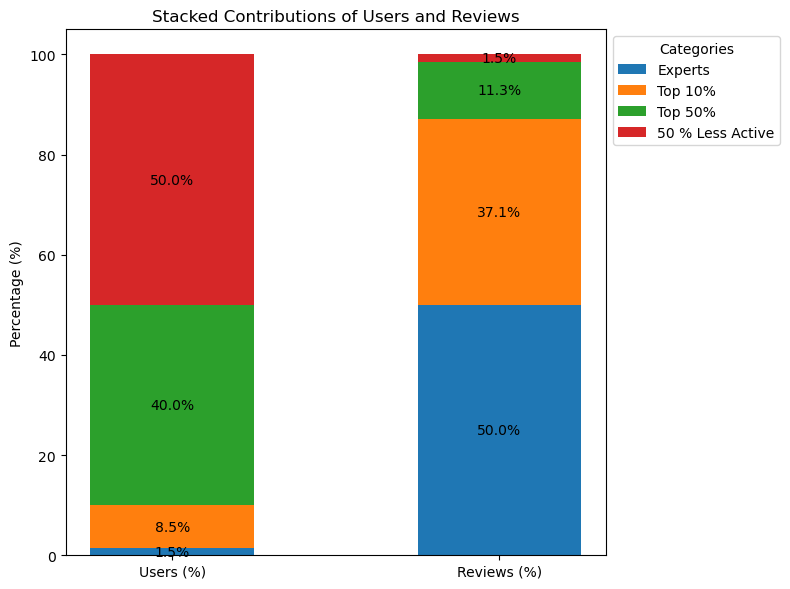

In [19]:
categories = ['Experts', 'Top 10%', 'Top 50%', '50 % Less Active']
bars = ['Users (%)', 'Reviews (%)']
pourcentage_users = [user_proportion_experts, user_proportion_10, user_proportion_50, user_proportion_less_active]
pourcentage_reviews = [review_proportion_experts, review_proportion_10, review_proportion_50, review_proportion_less_active]
data = np.array([pourcentage_users, pourcentage_reviews])

fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.5
x = np.arange(2)  # Two bars: Users (%) and Reviews (%)

# Plot each category as a stack
bottom_values = np.zeros(2)  # Starting point for stacking
for i, category in enumerate(categories):
    bars_plot = ax.bar(bars, data[:, i], bottom=bottom_values, label=category, width=bar_width)
    
    # Add annotations for each bar segment
    for bar in bars_plot:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, 
                bar.get_y() + height / 2, 
                f'{height:.1f}%', 
                ha='center', va='center', fontsize=10, color='black')
    
    bottom_values += data[:, i]

ax.set_ylabel('Percentage (%)')
ax.set_title('Stacked Contributions of Users and Reviews')
ax.legend(title="Categories", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()